# Decision Trees for Regression

In this example, we will learn how to train a decision tree with **scikit-learn**. <br/>

#### Dataset: California Housing

As an example dataset we will use the California Housing dataset. The data contains information from the 1990 California census.  A description of this dataset can be found here: https://www.kaggle.com/datasets/camnugent/california-housing-prices

Fortunately, the dataset is already provided in scikit-learn. So, there is no need to fetch the data from Kaggle manually. See: https://scikit-learn.org/stable/modules/generated/sklearn.datasets.fetch_california_housing.html

In [1]:
# Import modules which are relevant for this project
from sklearn.datasets import fetch_california_housing
import numpy as np
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score

In [2]:
# To ensure reproducibility

RANDOM_STATE = 42

np.random.seed(RANDOM_STATE)

## Load the dataset

In [3]:
dataset = fetch_california_housing(as_frame=True)

In [4]:
housing_df = dataset['data']
target_df = dataset['target']

housing_df['HousePrice'] = target_df

## Prepare a training, validation and testing set

In [5]:
train_df, test_df = train_test_split(housing_df, test_size=0.2)

# Prepare training features 
x_train = train_df.loc[:, train_df.columns != 'HousePrice'].values
y_train = train_df['HousePrice'].values

# Prepare testing features 
x_test = test_df.loc[:, test_df.columns != 'HousePrice'].values
y_test = test_df['HousePrice'].values 

## Searching the optimal hyperparameters using grid search

We have now learned that decision trees cannot only be regularized by their maximum depth but also by other hyperparameters, such as the minimum number of samples required in a leaf node. Ideally, in order to find the optimal choice of hyperparameters, many different combinations of hyperparameters have to be tested. While in the case of two hyperparameters, this is still easy to achieve with a nested for-loop, this process becomes tedious if we have to explore more hyperparameters.

To simplify the process of finding the right hyperparamter, scikit-learn provides the class `GridSearchCV`.`GridSearchCV` does an exhaustive search over specified parameter values for an estimator (model). All you need to do is tell it which hyperparameters you want it to experiment with, and what values to try out, and it will evaluate all the possible combinations of hyperparameter values using cross-validation.

In [6]:
# Specify the hyperparameters that should be tested.
# We want to test different parameters for max_depth (values from 5 to 30) and
# min_samples_leaf (values from 1 to 10)
param_grid = [
    {
        'max_depth': range(5, 30), 
        'min_samples_leaf': range(1, 10)
    }
]

# Initialize the model for which the best hyperparameters should be searched
# No hyperparameters need to be given at this point since GridSearchCV will use the
# set_params() method to set the hyperparameter of the model
model = DecisionTreeRegressor()

# GridSearchCV receives the model that should be tuned as well as the hyperparameters that should be checked.
# It searches for the hyperparameters that obtain the HIGHEST score on the validation sets obtained using cross-validation
# <cv> determines the cross-validation splitting strategy. If <cv> is not provided, 5-fold cross validation is used.
# <scoring> determines the metric that should be used to evaluate the performance.
grid_search = GridSearchCV(model, param_grid, cv=5, scoring='neg_mean_squared_error')

# Launches the hyperparameter search
grid_search.fit(x_train, y_train)

GridSearchCV(cv=5, estimator=DecisionTreeRegressor(),
             param_grid=[{'max_depth': range(5, 30),
                          'min_samples_leaf': range(1, 10)}],
             scoring='neg_mean_squared_error')

In [7]:
print('Best hyperparameters:', grid_search.best_params_)
print('Best score:', grid_search.best_score_)

Best hyperparameters: {'max_depth': 12, 'min_samples_leaf': 9}
Best score: -0.37154670864850575


## Evaluate the model performance on the testing set

In [8]:
model = DecisionTreeRegressor(**grid_search.best_params_)

# Re-Train the model on the entire training set with the best hyperparameters 
# found by grid search.
model.fit(x_train, y_train)

y_pred_test = model.predict(x_test)

rmse_test = mean_squared_error(y_test, y_pred_test, squared=False)

In [9]:
print(f'RMSE on the training set: ${rmse_test*100000}')

RMSE on the training set: $60154.12693266693


By searching for the optimal hyperparameters using grid search, we improved the performance of our decision tree regressor even further. <br/>
The final RMSE is \\$60154 (previously it was \\$64517).

### What are the most important features?

If we look at a decision tree, the most important features are likely to appear closer to the root of the tree, while less important features often appear closer to the leaves (or not at all). <br/>
This is because at each level, the decision tree regressor picks the feature that results in the largest decrease in the error criterion (e.g., MSE). We can quantify the importance of a feature by computing the (normalized) total reduction of the criterion brought by that feature.

See: https://github.com/scikit-learn/scikit-learn/blob/5444030d064d89bd4001efdb367f2c9685847f9a/sklearn/tree/_tree.pyx#L1266C39-L1266C39

In [59]:
feature_importances = model.feature_importances_

In [60]:
# Obtain the names of the features used for training
feature_names = train_df.loc[:, train_df.columns != 'HousePrice'].columns

# Sort features in ascending order
sorted_indices = feature_importances.argsort()

<BarContainer object of 8 artists>

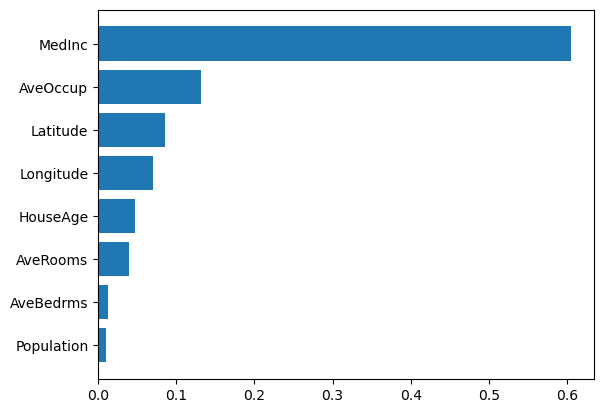

In [61]:
plt.barh(feature_names[sorted_indices], feature_importances[sorted_indices])